In [1]:
import torch
from pathlib import Path
import os
import numpy as np
import torch.nn as nn
from datetime import datetime

import torch.nn.functional as F

from fp16util import *
from resnet import *

In [2]:
from fastai.conv_learner import Learner, TrainingPhase, ModelData, accuracy, DecayType
from functools import partial
from PIL import Image

In [3]:
from fastai.conv_learner import *

In [4]:
import argparse, os, shutil, time, warnings

In [5]:
# from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path.home()/'data/cifar10/'
os.makedirs(PATH,exist_ok=True)

In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

In [7]:
workers = 7

## Model

In [8]:
# --
# Model definition
# Derived from models in `https://github.com/kuangliu/pytorch-cifar`

class PreActBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out + shortcut


class ResNet18(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2], num_classes=10):
        super().__init__()
        
        self.in_channels = 64
        
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, num_blocks[0], stride=1),
            self._make_layer(64, 128, num_blocks[1], stride=2),
            self._make_layer(128, 256, num_blocks[2], stride=2),
            self._make_layer(256, 256, num_blocks[3], stride=2),
        )
        
        self.classifier = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(PreActBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.prep(x)
        
        x = self.layers(x)
        
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)
        
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = x_max.view(x_max.size(0), -1)
        
        x = torch.cat([x_avg, x_max], dim=-1)
        
        x = self.classifier(x)
        
        return x

In [9]:
from autoaugment import CIFAR10Policy

In [10]:

def torch_loader(data_path, size, bs, val_bs=None):

    val_bs = val_bs or bs
    # Data loading code
    tfms = [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.24703,0.24349,0.26159))]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(), CIFAR10Policy(), 
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.CIFAR10(root=data_path, train=True, download=True, transform=train_tfms)
    val_dataset  = datasets.CIFAR10(root=data_path, train=False, download=True, transform=val_tfms)

    train_loader = DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [10]:
model = ResNet18()
model = model.cuda()

model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=1e-4
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 256
lrs = (0, 2e-1, 1e-2, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
    
learn = Learner.from_model_data(model, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=lrs[:2], lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases)

Files already downloaded and verified
Files already downloaded and verified


epoch      trn_loss   val_loss   accuracy                   
    0      1.764004   1.669598   0.4276    
    1      1.287702   1.376742   0.5179                     
    2      1.037439   1.514856   0.5442                     
    3      0.905836   0.901278   0.6948                      
    4      0.828128   0.779816   0.7373                      
    5      0.77735    1.133747   0.677                       
    6      0.728096   0.632654   0.7776                      
    7      0.677027   0.73582    0.7738                      
    8      0.634679   0.575511   0.8066                      
    9      0.612155   0.579327   0.8046                      
    10     0.581803   0.48661    0.8336                      
    11     0.559674   0.475198   0.8409                      
    12     0.552187   0.534952   0.8272                      
    13     0.539548   0.605655   0.8049                      
    14     0.543335   0.538854   0.8243                      
    15     0.507774   0.47060

[0.195781640625, 0.9330999994277954]

In [ ]:
model = ResNet18()
model = model.cuda()

model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=5e-4
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 512
lrs = (0, 4e-1, 2e-2, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
    
learn = Learner.from_model_data(model, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=lrs[:2], lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases)

Files already downloaded and verified
Files already downloaded and verified


epoch      trn_loss   val_loss   accuracy                 
    0      1.896388   1.69485    0.3945    
    1      1.489245   1.427309   0.5192                   
    2      1.17452    1.538377   0.5762                   
    3      0.980957   0.925872   0.6939                    
    4      0.871169   0.68867    0.7655                    
    5      0.795293   0.770804   0.7301                    
    6      0.747305   0.606716   0.7926                    
    7      0.699317   0.74764    0.7397                    
    8      0.664783   0.593196   0.8032                    
    9      0.649147   1.022948   0.6906                    
    10     0.644033   0.675278   0.7738                    
    11     0.626524   0.685498   0.777                     
    12     0.626378   0.682255   0.7753                    
    13     0.643646   0.545291   0.8178                    
    14     0.627443   0.630255   0.7754                    
    15     0.630527   0.655323   0.7877                    

In [11]:
class MixUpDataLoader(object):
    """
    Creates a new data loader with mixup from a given dataloader.
    
    Mixup is applied between a batch and a shuffled version of itself. 
    If we use a regular beta distribution, this can create near duplicates as some lines might be 
    1 * original + 0 * shuffled while others could be 0 * original + 1 * shuffled, this is why
    there is a trick where we take the maximum of lambda and 1-lambda.
    
    Arguments:
    dl (DataLoader): the data loader to mix up
    alpha (float): value of the parameter to use in the beta distribution.
    """
    def __init__(self, dl, alpha):
        self.dl, self.alpha = dl, alpha
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for (x, y) in iter(self.dl):
            #Taking one different lambda per image speeds up training 
            lambd = np.random.beta(self.alpha, self.alpha, y.size(0))
            #Trick to avoid near duplicates
            lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
            lambd = to_gpu(VV(lambd)).half()
            shuffle = torch.randperm(y.size(0))
            x1, y1 = x[shuffle], y[shuffle]
            yield (x.half() * lambd.view(lambd.size(0),1,1,1) + x1.half() * (1-lambd).view(lambd.size(0),1,1,1), [y, y1, lambd])
            
class MixUpLoss(nn.Module):
    """
    Adapts the loss function to go with mixup.
    
    Since the targets aren't one-hot encoded, we use the linearity of the loss function with
    regards to the target to mix up the loss instead of one-hot encoded targets.
    
    Argument:
    crit: a loss function. It must have the parameter reduced=False to have the loss per element.
    """
    def __init__(self, crit):
        super().__init__()
        self.crit = crit()
        
    def forward(self, output, target):
        if not isinstance(target, list): return self.crit(output, target).mean()
        loss1, loss2 = self.crit(output,target[0]), self.crit(output,target[1])
        return (loss1 * target[2] + loss2 * (1-target[2])).mean()

In [20]:
# m = wrn_22()
# opt_fn = partial(optim.Adam, betas=(0.95,0.99))
# learn = ConvLearner.from_model_data(m, data)
# learn.metrics = [accuracy]
# wd=1e-4
# learn.opt_fn = opt_fn
# learn.data.trn_dl = mixup_dl
# learn.crit = MixUpLoss(partial(nn.CrossEntropyLoss, reduce=False))

In [22]:
model = ResNet18()
model = model.cuda()

model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=1e-4
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 256
lrs = (0, 2e-1, 1e-2, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
mixup_dl = MixUpDataLoader(data.trn_dl, 0.6)
    
learn = Learner.from_model_data(model, data)
# learn.half()
learn.data.trn_dl = mixup_dl
learn.crit = MixUpLoss(partial(nn.CrossEntropyLoss, reduce=False))
learn.metrics = [accuracy]
learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)

# opt_fn = partial(optim.Adam, betas=(0.95,0.99))
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=lrs[:2], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR, wd_loss=False),
]

learn.fit_opt_sched(phases)

Files already downloaded and verified
Files already downloaded and verified


epoch      trn_loss   val_loss   accuracy                   
    0      2.014805   1.654992   0.394     
    1      1.780525   1.236267   0.5818                     
    2      1.641302   1.180612   0.6062                     
    3      1.573484   1.190717   0.605                      
    4      1.50012    1.000758   0.6753                     
    5      1.438768   0.765143   0.747                      
    6      1.413901   0.72423    0.771                      
    7      1.378722   0.798111   0.7356                     
    8      1.351556   0.68767    0.793                      
    9      1.317362   0.704825   0.7809                     
    10     1.30258    0.605433   0.8158                     
    11     1.283154   0.653912   0.7936                     
    12     1.276553   0.575738   0.8386                     
    13     1.267437   0.547024   0.8428                     
    14     1.255462   0.494032   0.8588                     
    15     1.240891   0.48393    0.8655  

[0.29680078125, 0.925799999332428]

In [26]:
model = ResNet18()
model = model.cuda()

# model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=1e-5
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 512
lrs = (0, 3e-3, 2e-4, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
mixup_dl = MixUpDataLoader(data.trn_dl, 0.6)
    
learn = Learner.from_model_data(model, data)
learn.half()
learn.data.trn_dl = mixup_dl
learn.crit = MixUpLoss(partial(nn.CrossEntropyLoss, reduce=False))
learn.metrics = [accuracy]
# learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)

learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=lrs[:2], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR, wd_loss=False),
]

learn.fit_opt_sched(phases)

Files already downloaded and verified
Files already downloaded and verified


epoch      trn_loss   val_loss   accuracy                 
    0      2.090858   1.562464   0.4282    
    1      1.867956   1.38808    0.5056                   
    2      1.699242   1.119784   0.615                    
    3      1.585528   0.949446   0.6759                   
    4      1.510021   0.903056   0.6909                   
    5      1.450629   0.806435   0.7549                   
    6      1.417132   0.739396   0.7768                   
    7      1.385784   0.741787   0.7661                   
    8      1.355923   0.739975   0.7696                   
    9      1.337761   0.613872   0.8132                   
    10     1.329115   0.696055   0.7866                   
    11     1.307615   0.60846    0.8377                   
    12     1.302465   0.725997   0.7926                   
    13     1.287697   0.580276   0.8339                   
    14     1.279528   0.604704   0.823                    
    15     1.249727   0.841876   0.7368                   
    16     1

[0.30922578125, 0.9208999980926513]

In [30]:
model = ResNet18()
model = model.cuda()

# model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=1e-4
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 256
lrs = (0, 2e-3, 1e-4, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
mixup_dl = MixUpDataLoader(data.trn_dl, 0.6)
    
learn = Learner.from_model_data(model, data)
learn.half()
learn.data.trn_dl = mixup_dl
learn.crit = MixUpLoss(partial(nn.CrossEntropyLoss, reduce=False))
learn.metrics = [accuracy]
# learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)

learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd}

Files already downloaded and verified
Files already downloaded and verified


In [28]:
learn.lr_find()

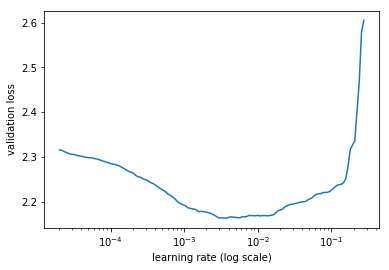

In [29]:
learn.sched.plot()

In [31]:
phases = [
    TrainingPhase(**def_phase, epochs=15, lr=lrs[:2], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR, wd_loss=False),
]

learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss   accuracy                   
    0      2.034803   1.607208   0.4254    
    1      1.791129   1.4785     0.4813                     
    2      1.639594   1.141684   0.5963                     
    3      1.551836   0.995409   0.661                      
    4      1.483802   0.949103   0.6885                     
    5      1.438598   0.73587    0.7622                     
    6      1.393267   0.776724   0.75                       
    7      1.365727   0.69194    0.78                       
    8      1.343344   0.662018   0.7902                     
    9      1.323702   0.657792   0.7974                     
    10     1.312869   0.63128    0.7912                     
    11     1.295111   0.626956   0.7985                     
    12     1.265577   0.51227    0.8517                     
    13     1.269983   0.522676   0.8464                     
    14     1.250852   0.53137    0.8413                     
    15     1.231268   0.495957   0.8567  

[0.2789125, 0.930899999332428]

In [33]:
model = ResNet18()
model = model.cuda()

# model = network_to_half(model)

# AS: todo: don't copy over weights as it seems to help performance

wd=1e-4
lr=1e-1
momentum = 0.9
# learn.clip = 1e-1
bs = 256
lrs = (0, 2e-3, 1e-4, 0)
sz=32


data = torch_loader(PATH, sz, bs, bs*2)
mixup_dl = MixUpDataLoader(data.trn_dl, 0.6)
    
learn = Learner.from_model_data(model, data)
learn.half()
learn.data.trn_dl = mixup_dl
learn.crit = MixUpLoss(partial(nn.CrossEntropyLoss, reduce=False))
learn.metrics = [accuracy]
# learn.opt_fn = partial(torch.optim.SGD, nesterov=True, momentum=0.9)

learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))

def_phase = {'opt_fn':learn.opt_fn, 'wds':wd}
phases = [
    TrainingPhase(opt_fn=partial(torch.optim.SGD, nesterov=True, momentum=0.9), wds=wd, epochs=5, lr=(0,2e-2), lr_decay=DecayType.LINEAR, wd_loss=False),
#     TrainingPhase(opt_fn=partial(torch.optim.SGD, nesterov=True, momentum=0.9), wds=wd, epochs=15, lr=(0,2e-1), lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(2e-4,2e-3), lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=15, lr=lrs[1:3], lr_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=5, lr=lrs[-2:], lr_decay=DecayType.LINEAR, wd_loss=False),
]

learn.fit_opt_sched(phases)

Files already downloaded and verified
Files already downloaded and verified


epoch      trn_loss   val_loss   accuracy                   
    0      2.121836   1.754028   0.352     
    1      1.873292   1.372998   0.5145                     
    2      1.693561   1.335194   0.5366                     
    3      1.576514   1.131819   0.6077                     
    4      1.481769   0.9215     0.6833                     
    5      1.490514   0.810545   0.7316                     
    6      1.48339    0.810693   0.7328                     
    7      1.489809   0.807862   0.735                      
    8      1.497329   0.81227    0.732                      
 51%|█████     | 100/196 [00:04<00:03, 24.30it/s, loss=1.5]

Process Process-1477:


KeyboardInterrupt: 

Process Process-1475:
Traceback (most recent call last):
Process Process-1476:
Process Process-1473:
Process Process-1472:
Process Process-1471:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-1474:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py",